# Generalized Linear Models

### Environment Setup
**⚠️Note: If running on a new environment, run this cell once and then restart the kernel⚠️**

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

%matplotlib inline

### Downloading Files

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
# dandiset_id = "000563"
# dandi_filepath = "sub-688546/sub-688546_ses-1295360519.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.58.1) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Selecting Neurons

In [5]:
spike_times = nwb.units[0].spike_times.item()

### Making Stim Trace

In [6]:
nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [7]:
flashes_table = nwb.intervals["flashes_presentations"]
# flashes_table = nwb.intervals["UniqueFFF_presentations"]
flashes_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1282.632614,1282.882832,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1284.634334,1284.884540,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1286.636014,1286.886217,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1288.637634,1288.887855,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1290.639354,1290.889562,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1292.641034,1292.891240,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1294.642714,1294.892917,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1296.644364,1296.894572,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1298.646074,1298.896272,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


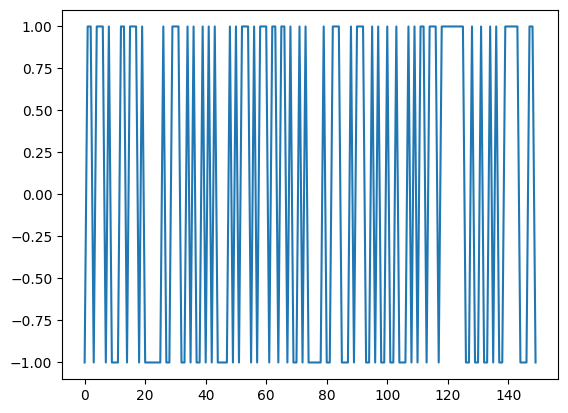

In [8]:
plt.plot([float(color) for color in flashes_table.color])

In [9]:
len(set(flashes_table.color))

2

### Getting Running Times

In [10]:
running_data = nwb.processing["running"]["running_speed"].data
running_timestamps = nwb.processing["running"]["running_speed"].timestamps

### Interpolating Times

In [11]:
first_run_time = running_timestamps[0]
last_run_time = running_timestamps[-1]
first_stim_time = flashes_table.start_time[0]
last_stim_time = flashes_table.stop_time[-1]
# first_time = max(first_stim_time, first_run_time)
# last_time = min(last_stim_time, last_run_time)
first_time = first_stim_time
last_time = last_stim_time

run_start_idx, run_end_idx = np.searchsorted(running_timestamps, [first_time, last_time])
stim_start_idx, stim_end_idx = np.searchsorted(flashes_table.start_time, [first_time, last_time])

running_data_slice = running_data[run_start_idx:run_end_idx]
running_timestamps_slice = running_timestamps[run_start_idx:run_end_idx]

print("first time:", first_time, "last time:", last_time)

first time: 1282.6326142945445 last time: 1581.1321471083802


In [12]:
# bin_res = np.mean(np.diff(flashes_table.start_time)) / 3
# interp_hz = 1/bin_res
interp_hz = 100

In [13]:
time_axis = np.arange(first_time, last_time, step=(1/interp_hz))
interp_flashes = np.zeros(len(time_axis))

for index, individual_time in enumerate(time_axis):
    for i in range(len(flashes_table)):
        flash_start, flash_stop = flashes_table.start_time[i], flashes_table.stop_time[i]
        if individual_time >= flash_start and individual_time < flash_stop:
            if flashes_table.color[i] == "1.0":
                interp_flashes[index] = 1.0

# i = 0 # stim table idx
# flash_start, flash_stop = flashes_table.start_time[i], flashes_table.stop_time[i]

# l = []
# for index, individual_time in enumerate(time_axis):
#     while individual_time < flash_start:
#         i += 1
#         flash_start, flash_stop = flashes_table.start_time[i], flashes_table.stop_time[i]
#     print(flashes_table.color[i])
#     l.append(flashes_table.color[i])
#     interp_flashes[index] = float(flashes_table.color[i])

# colors = flashes_table.color[stim_start_idx:stim_end_idx]
# flash_frames = np.zeros(len(colors))
# for i, color in enumerate(colors):
#     flash_frames[i] = 1.0 if color == "1.0" else 0

# colors = flashes_table.color[stim_start_idx:stim_end_idx]
# flash_frames = np.zeros(len(colors))
# for i, color in enumerate(colors):
#     flash_frames[i] = float(color)

# time_axis = np.arange(first_time, last_time, step=(1/interp_hz))
# f = interpolate.interp1d(flashes_table.start_time, flash_frames, axis=0, kind="nearest", fill_value="extrapolate")
# interp_flashes = f(time_axis)


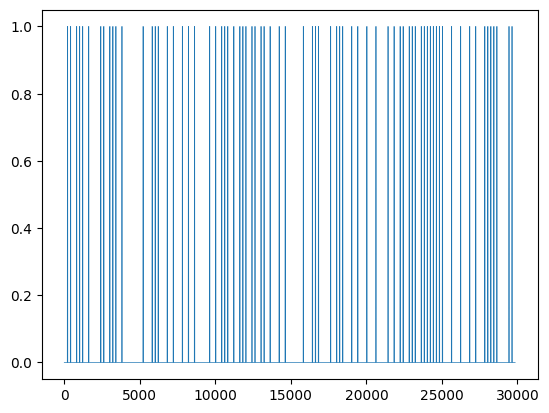

In [14]:
plt.plot(interp_flashes, lw=0.5)

In [15]:
# generate regularly-space x values and interpolate along it
# time_axis = np.arange(first_time, last_time, step=(1/interp_hz))
# f = interpolate.interp1d(running_timestamps_slice, running_data_slice, axis=0, kind="nearest", fill_value="extrapolate")
# interp_running = f(time_axis)

In [16]:
# plt.plot(interp_running)
# norm_running = (interp_running-np.min(interp_running)) / (np.max(interp_running)-np.min(interp_running))
# plt.plot(norm_running)

In [17]:
print(len(interp_flashes))
# print(len(norm_running))

29850


### Combine Stims

In [18]:
# coefficient to add running to stimulus
mod_coef = 0.25

In [19]:
# exog = interp_flashes * (norm_running * mod_coef)
# plt.plot(exog)

In [20]:
# exog = 0.75*interp_flashes + 0.25*norm_running
# plt.plot(exog)

In [21]:
exog = interp_flashes

### Building Design Matrix

In [22]:
# length of filter (# bins)
ntfilt = 200

In [23]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [24]:
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)

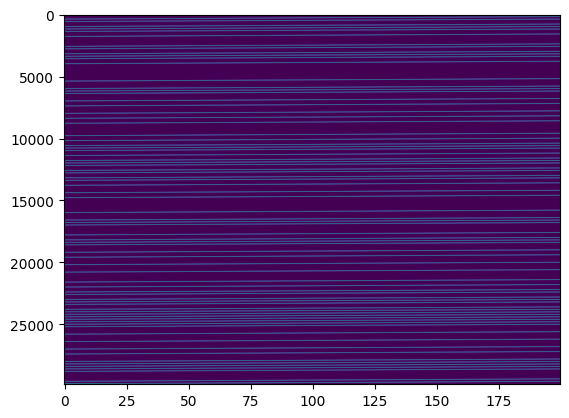

In [25]:
plt.imshow(design_mat, aspect="auto")

In [26]:
design_mat.shape

(29849, 200)

### Getting STA

In [27]:
def STASTD(design_mat, spikes_binned, num_spikes):
    spike_triggered = (design_mat.transpose()*spikes_binned).transpose()
    spike_triggered_avg = np.mean(spike_triggered, axis=0)
    spike_triggered_std = np.std(spike_triggered, axis=0)
    return spike_triggered_avg, spike_triggered_std

def STA(design_mat, spikes_binned, num_spikes):
    return (design_mat.T @ spikes_binned) / num_spikes

def WSTA(design_mat, spikes_binned, num_spikes, return_both=False):
    sta = STA(design_mat, spikes_binned, num_spikes)
    wsta = inv(design_mat.T @ design_mat) @ sta * num_spikes
    if return_both:
        return sta, wsta
    return wsta

In [28]:
num_spikes = len(time_axis)
# spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, time_axis)

In [29]:
design_mat.shape

(29849, 200)

In [30]:
spikes_binned.shape

(29849,)

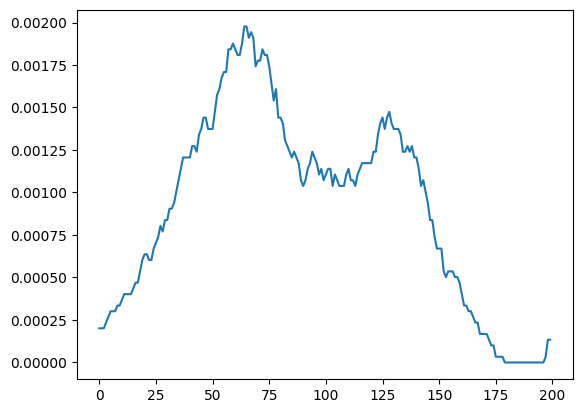

In [31]:
plt.plot(STA(design_mat, spikes_binned, num_time_bins))

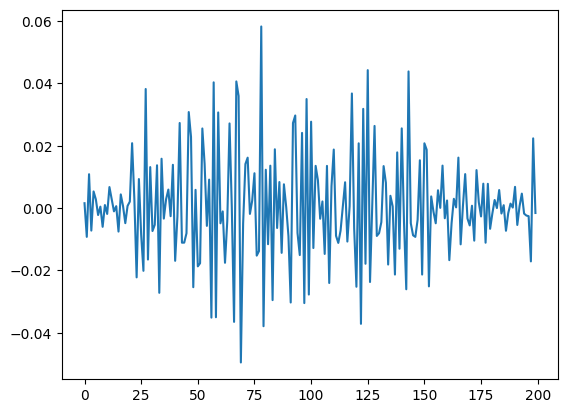

In [32]:
plt.plot(WSTA(design_mat, spikes_binned, num_spikes))

### Running MLE

In [33]:
def MLE(design_mat, spikes_binned):
    design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

    glm_poisson_exp = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                            family=sm.families.Poisson())

    pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')

    # pGLM_const = glm_poisson_exp[-1].fit_['beta0'] # constant ("dc term)")
    pGLM_const = pGLM_results.params[0]
    pGLM_filt = pGLM_results.params[1:] # stimulus filter

    return pGLM_filt, pGLM_const

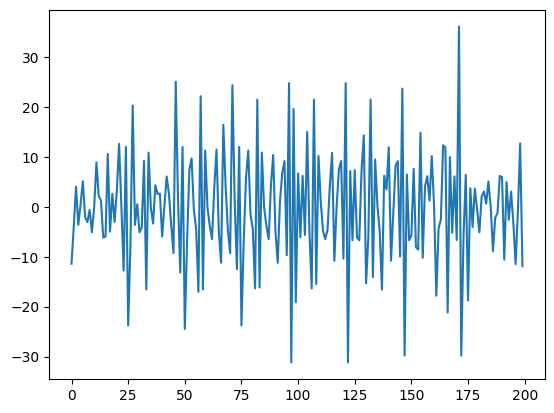

In [34]:
filt, const = MLE(design_mat, spikes_binned)
plt.plot(filt)

### running on many cells

In [35]:
def get_filter(spike_times, method="poisson"):
    # these_spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
    # these_spikes_binned,_ = np.histogram(spike_times, these_spikes_bin_centers)
    these_spikes_binned, _ = np.histogram(spike_times, time_axis)

    print(len(these_spikes_binned))
    print(design_mat.shape)

    if method == "poisson":
        return MLE(design_mat, these_spikes_binned)
    elif method == "sta":
        return STA(design_mat, these_spikes_binned, num_spikes), 0
    elif method == "wsta":
        return WSTA(design_mat, these_spikes_binned, num_spikes), 0
    elif method == "wsta+sta":
        wsta, sta = WSTA(design_mat, these_spikes_binned, num_spikes, return_both=True)
        return wsta, sta, 0
    elif method == "std":
        return STASTD(design_mat, these_spikes_binned, num_spikes)

In [36]:
stas = []
stss = []
for i in range(1000):
    if nwb.units[i].quality.item() == "good":
        print(i)
        sta, sts = get_filter(nwb.units[i].spike_times.item(), method="std")
        stas.append(sta)
        stss.append(sts)

0
29849
(29849, 200)
1
29849
(29849, 200)
2
29849
(29849, 200)
3
29849
(29849, 200)
4
29849
(29849, 200)
5
29849
(29849, 200)
6
29849
(29849, 200)
7
29849
(29849, 200)
8
29849
(29849, 200)
9
29849
(29849, 200)
10
29849
(29849, 200)
11
29849
(29849, 200)
12
29849
(29849, 200)
13
29849
(29849, 200)
14
29849
(29849, 200)
15
29849
(29849, 200)
16
29849
(29849, 200)
17
29849
(29849, 200)
18
29849
(29849, 200)
19
29849
(29849, 200)
20
29849
(29849, 200)
21
29849
(29849, 200)
22
29849
(29849, 200)
23
29849
(29849, 200)
24
29849
(29849, 200)
25
29849
(29849, 200)
26
29849
(29849, 200)
27
29849
(29849, 200)
28
29849
(29849, 200)
29
29849
(29849, 200)
30
29849
(29849, 200)
31
29849
(29849, 200)
32
29849
(29849, 200)
33
29849
(29849, 200)
34
29849
(29849, 200)
35
29849
(29849, 200)
36
29849
(29849, 200)
37
29849
(29849, 200)
38
29849
(29849, 200)
39
29849
(29849, 200)
40
29849
(29849, 200)
42
29849
(29849, 200)
43
29849
(29849, 200)
44
29849
(29849, 200)
45
29849
(29849, 200)
46
29849
(29849, 200

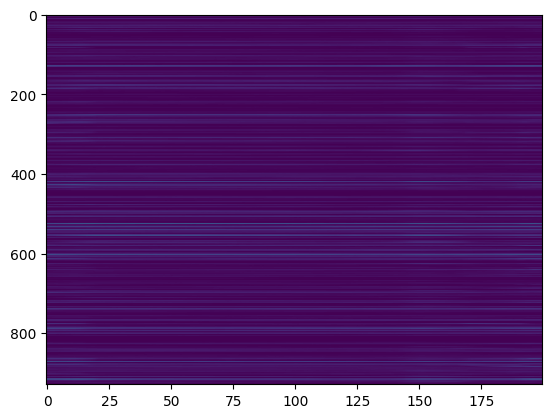

In [37]:
plt.imshow(np.array(stas), aspect="auto")

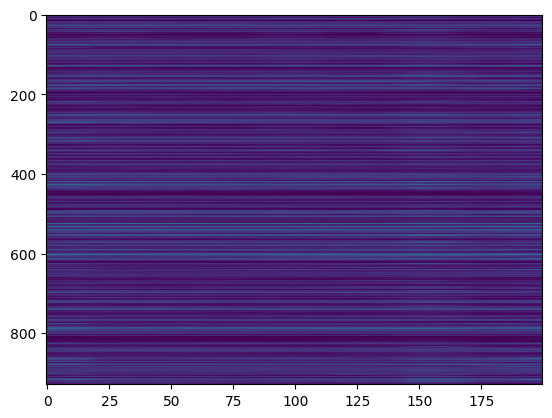

In [38]:
plt.imshow(np.array(stss), aspect="auto")

In [39]:
len(stas)

929

In [45]:
selected_units = [119, 125, 127, 150, 160, 173, 174, 234, 236, 291, 294, 301, 309, 310, 324, 326, 332, 337, 339, 343, 356, 361, 369, 380, 420, 421, 422, 472, 479, 461, 492, 494, 502, 506, 516, 521, 522, 530, 546, 552, 553, 556, 559, 570, 582, 625, 626, 651, 652, 664, 669, 674, 693, 694, 695, 696, 710, 713, 717, 720, 724, 730, 731, 744, 754, 759, 763, 777, 833, 834, 835, 836, 844, 850, 855, 867, 881, 895, 905, 907, 915, 920, 922, 925]

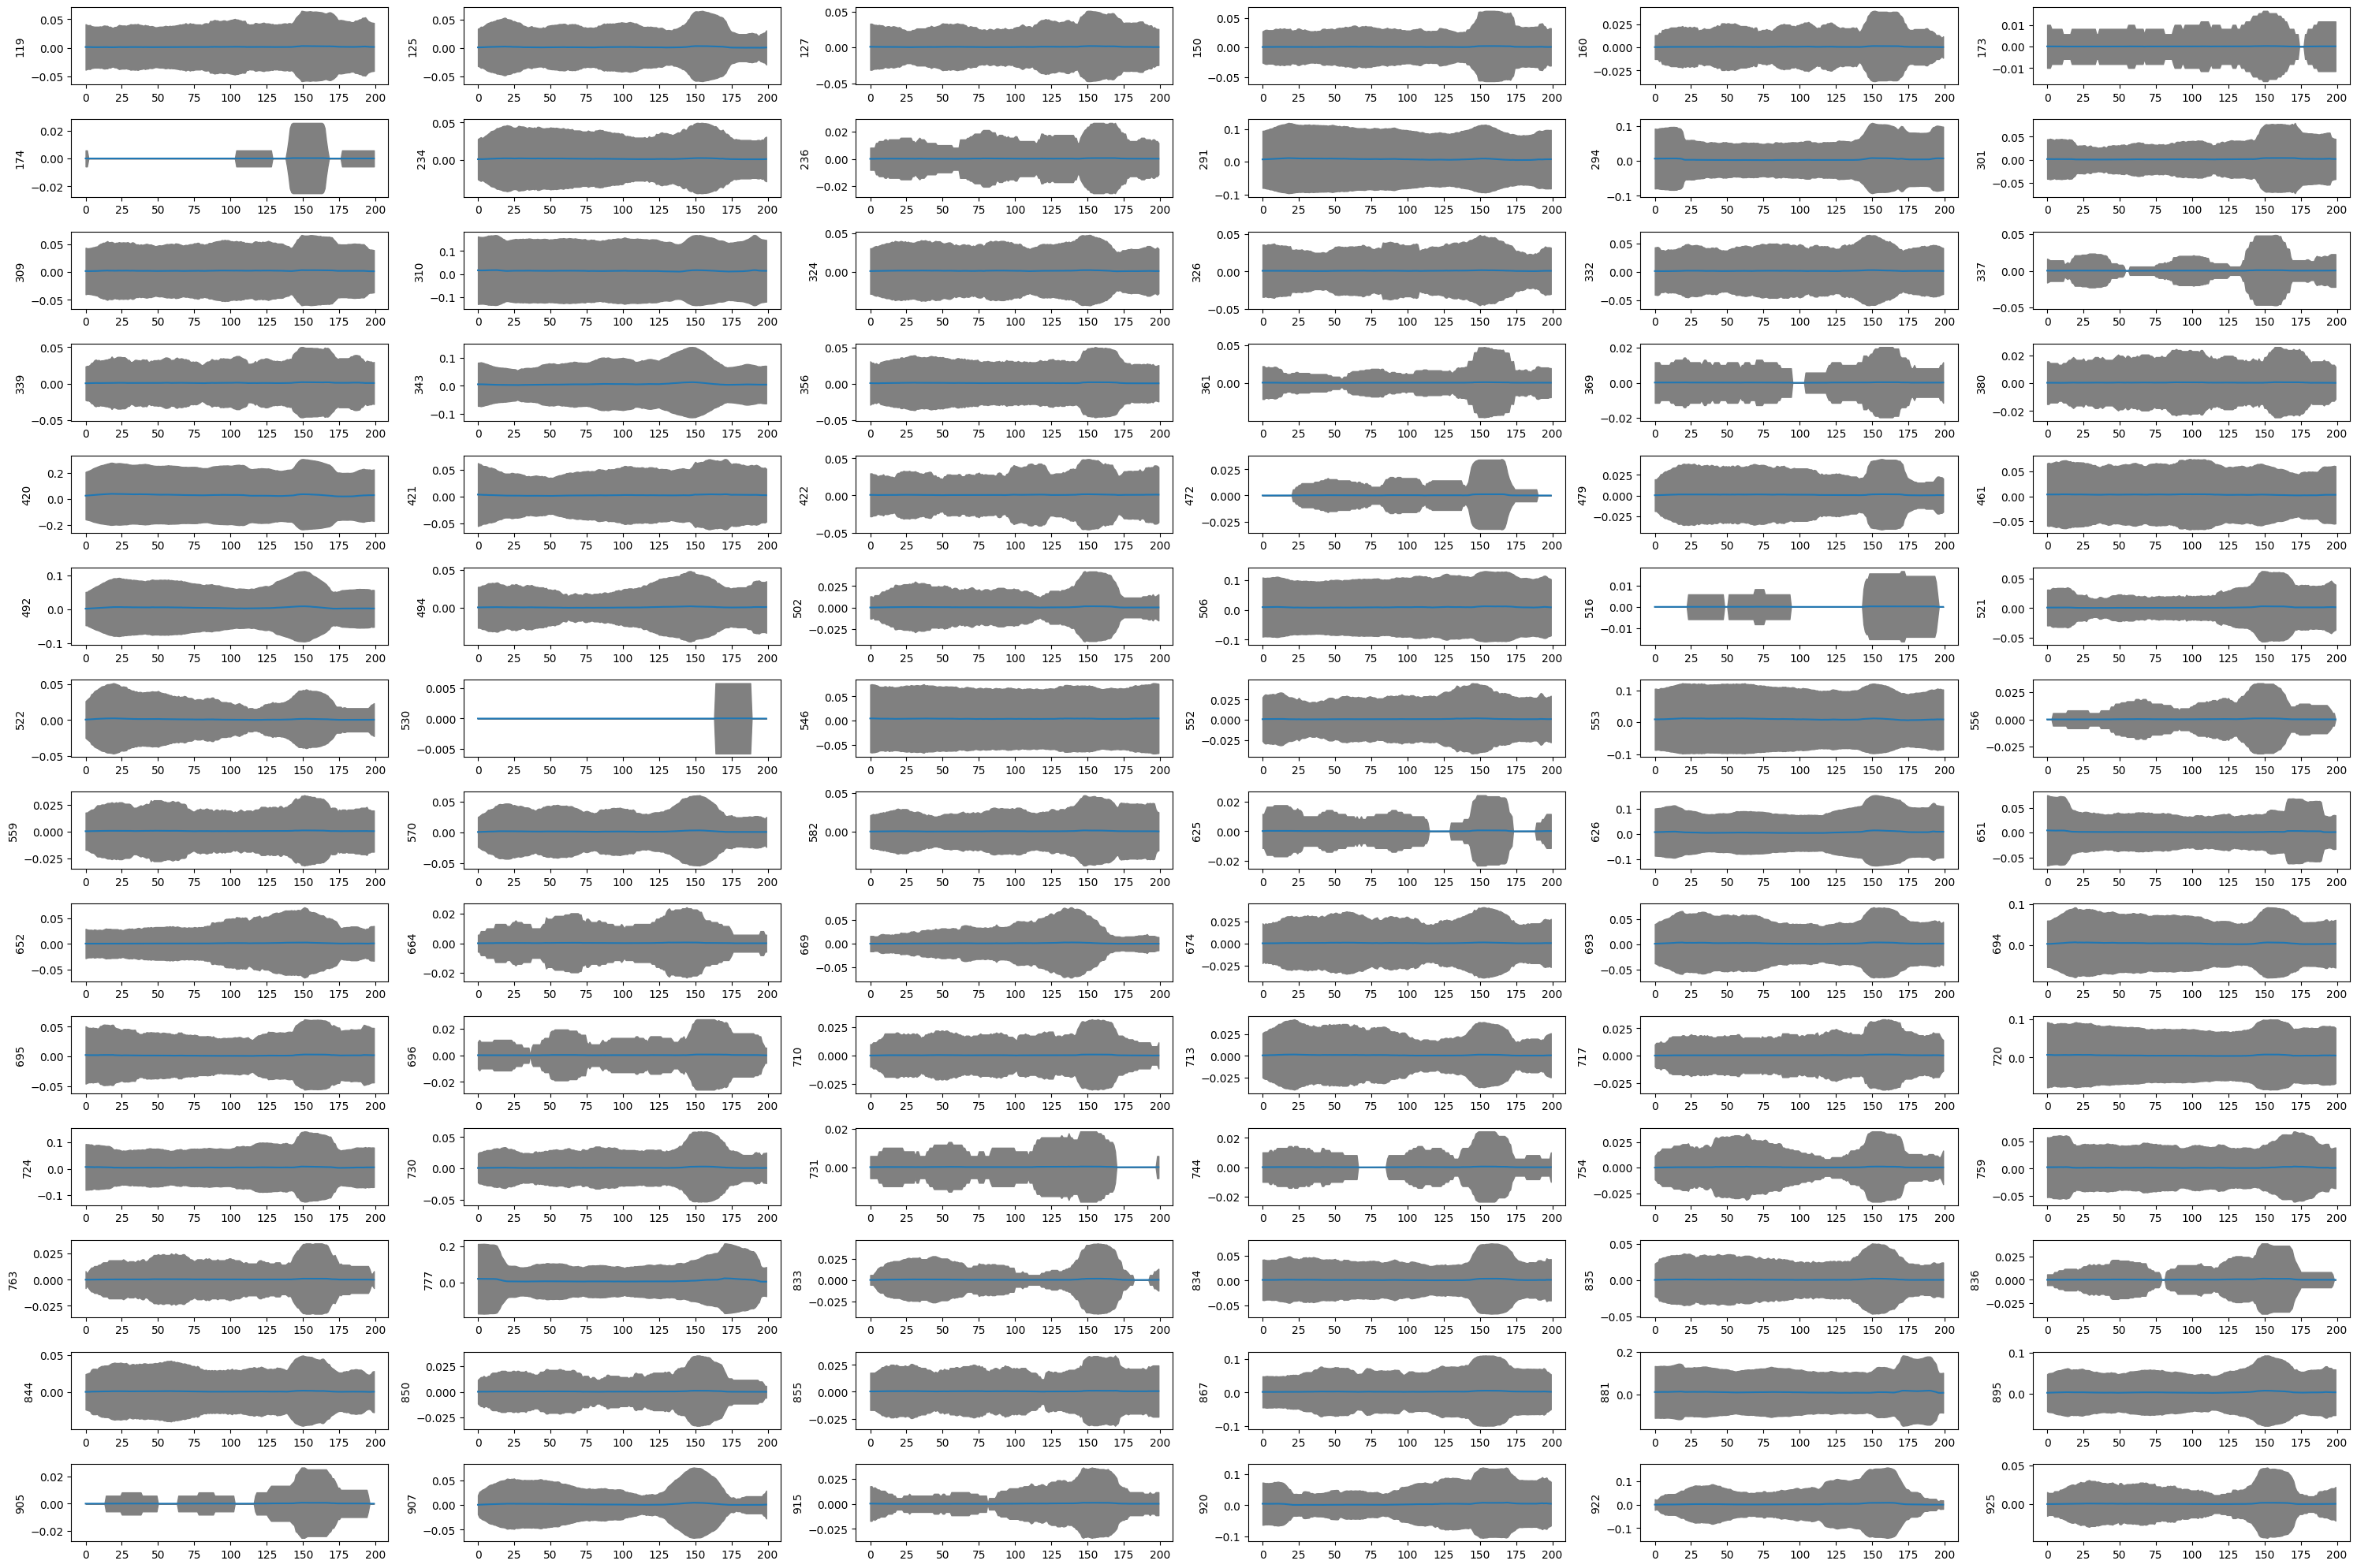

In [50]:
ncols=6

fig, axes = plt.subplots((len(selected_units)//ncols), ncols, figsize=(30,20))
# for i in range(len(stas)):
for j, i in enumerate(selected_units):
    sta = stas[i]
    sts = stss[i]

    row = j // ncols
    col = j % ncols
    axes[row][col].plot(sta)
    axes[row][col].set_ylabel(i)
    axes[row][col].fill_between(range(len(sta)), sta+sts, sta-sts, color="grey")

fig.tight_layout()

In [41]:
# wsta_ymax, wsta_ymin = 0, 0
# for i in range(len(stas)):
#     sta = stas[i]
#     if max(sta) > wsta_ymax:
#         wsta_ymax = max(sta)
#     if min(sta) < wsta_ymin:
#         wsta_ymin = min(sta)

# fig, axes = plt.subplots((len(stas)//ncols)+1, ncols, figsize=(30,200))
# for i in range(len(stas)):
#     wsta = wstas[i]

#     row = i // ncols
#     col = i % ncols

#     axes[row][col].plot(wsta)
    # axes[row][col].set_ylim([wsta_ymin, wsta_ymax])